This analysis examines credit card holder usage data and utilizes k-means clustering to identify useful patterns of behavior.

In [1]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
# Importing the dataset
data = pd.read_csv('cadata.csv')
print(data.columns)
print("dimension of data: {}".format(data.shape))
data.info()
data.head()

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS',
       'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')
dimension of data: (6906, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6906 entries, 0 to 6905
Data columns (total 15 columns):
CUST_ID                             6906 non-null object
BALANCE                             6906 non-null float64
BALANCE_FREQUENCY                   6906 non-null float64
PURCHASES                           6906 non-null float64
ONEOFF_PURCHASES                    6906 non-null float64
INSTALLMENTS_PURCHASES              6906 non-null float64
PURCHASES_FREQUENCY                 6906 non-null float64
ONEOFF_PURCHASES_FREQUENCY          6906 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    6906 non-null float6

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.166667,0.000000,0.083333,2,1000.0,201.802084,139.509787,0.0,12
1,C10003,2495.148862,1.000000,773.17,773.17,0.00,1.000000,1.000000,0.000000,12,7500.0,622.066742,627.284787,0.0,12
2,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,0.083333,0.083333,0.000000,1,7500.0,0.000000,NaN,0.0,12
3,C10005,817.714335,1.000000,16.00,16.00,0.00,0.083333,0.083333,0.000000,1,1200.0,678.334763,244.791237,0.0,12
4,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.666667,0.000000,0.583333,8,1800.0,1400.057770,2407.246035,0.0,12


In [3]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,6906.000000,6906.000000,6906.00000,6906.000000,6906.000000,6906.000000,6906.000000,6906.000000,6906.000000,6906.000000,6906.000000,6669.000000,6906.000000,6906.000000
mean,1391.124294,0.875828,1300.01406,767.783700,532.606509,0.635265,0.262368,0.472084,19.063568,4630.069717,1752.710455,822.236836,0.186019,11.576021
std,2037.957692,0.238088,2351.74969,1853.692453,997.578372,0.341552,0.315645,0.392193,26.791844,3729.790198,2927.401991,2293.780326,0.317224,1.263456
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,150.000000,0.000000,0.019163,0.000000,6.000000
25%,85.064043,0.875000,243.01000,0.000000,0.000000,0.333333,0.000000,0.000000,5.000000,1700.000000,391.271838,162.122511,0.000000,12.000000
50%,609.715242,1.000000,594.79000,194.335000,233.310000,0.666667,0.100000,0.416667,11.000000,3500.000000,885.157419,246.804668,0.000000,12.000000
75%,1773.145345,1.000000,1471.22250,854.537500,627.340000,1.000000,0.416667,0.888889,23.000000,6500.000000,1942.046036,762.149727,0.250000,12.000000
max,19043.138560,1.000000,49039.57000,40761.250000,22500.000000,1.000000,1.000000,1.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Preprocessing

In [4]:
# Identify problem data values
data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    237
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [5]:
# examine empty values
missing = data.loc[data['MINIMUM_PAYMENTS'].isnull()]
missing.head(15)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,0.083333,0.083333,0.000000,1,7500.0,0.000000,NaN,0.0,12
37,C10047,2242.311686,1.000000,437.00,97.00,340.00,0.333333,0.083333,0.333333,5,2400.0,0.000000,NaN,0.0,12
44,C10056,6.660517,0.636364,310.00,0.00,310.00,0.666667,0.000000,0.666667,8,1000.0,417.016763,NaN,0.0,12
45,C10057,1311.995984,1.000000,1283.90,1283.90,0.00,0.250000,0.250000,0.000000,6,6000.0,0.000000,NaN,0.0,12
46,C10058,3625.218146,1.000000,313.27,313.27,0.00,0.250000,0.250000,0.000000,4,4000.0,0.000000,NaN,0.0,12
51,C10065,7.152356,0.090909,840.00,840.00,0.00,0.083333,0.083333,0.000000,1,1600.0,0.000000,NaN,0.0,12
75,C10098,1307.717841,1.000000,405.60,405.60,0.00,0.166667,0.166667,0.000000,2,2400.0,0.000000,NaN,0.0,12
76,C10099,2329.485768,1.000000,213.34,213.34,0.00,0.250000,0.250000,0.000000,3,2400.0,0.000000,NaN,0.0,12
82,C10108,0.624240,0.090909,389.96,0.00,389.96,1.000000,0.000000,1.000000,31,4500.0,0.000000,NaN,0.0,12
94,C10126,1464.324632,1.000000,1174.39,1174.39,0.00,0.250000,0.250000,0.000000,8,9000.0,0.000000,NaN,0.0,12


In [6]:
# Most min_payment values happen when payment=0; Replace missing values w/zero or median
data.loc[data['PAYMENTS'] == 0, 'MINIMUM_PAYMENTS'] = 0
med = data['MINIMUM_PAYMENTS'].median()
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS'] = med

In [7]:
data.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [8]:
# Remove ID column
data = data.drop(columns=['CUST_ID'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021494D6DFD0>,
      dtype=object)

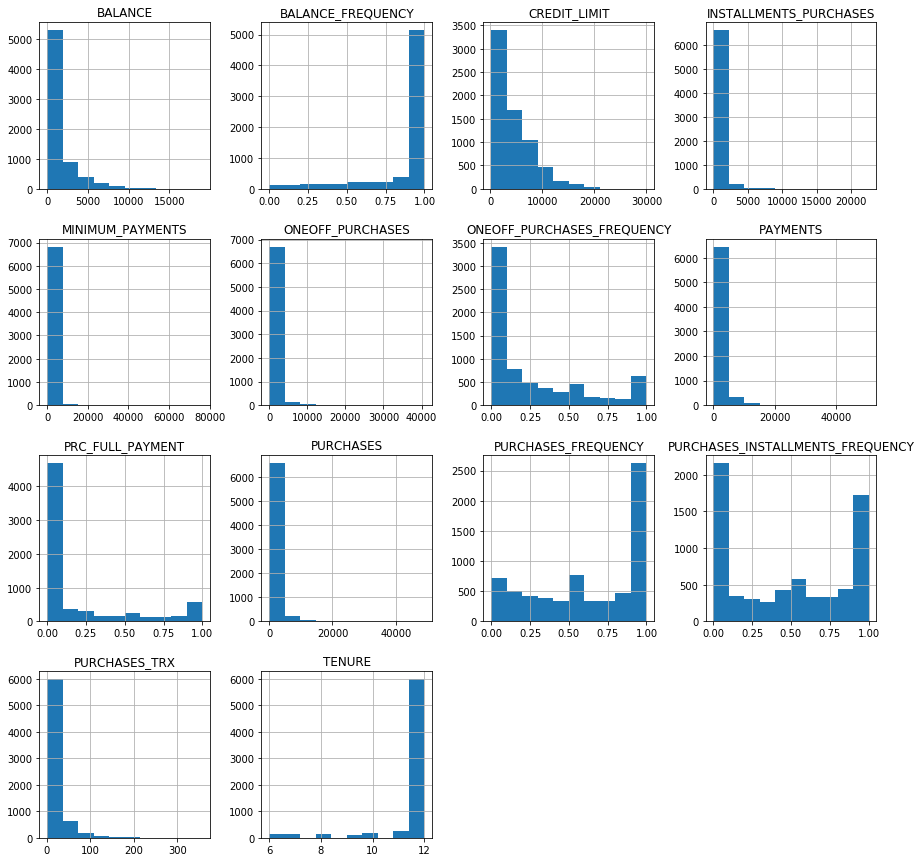

In [9]:
# Visualize dataset
data.hist(figsize=(15, 15))

In [10]:
# Scale feature data
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

# Convert back from array to dataframe
data_scaled = pd.DataFrame(scaled, columns=data.columns)

C:\Users\my_di\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


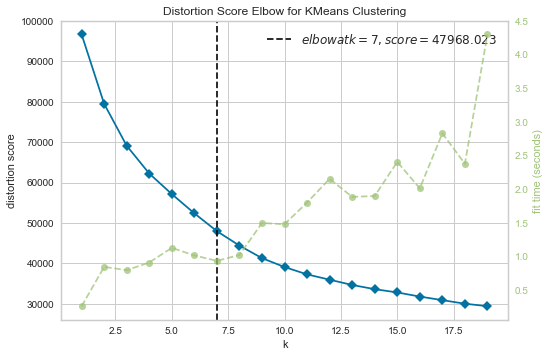

In [11]:
# determine number of k clusters using the Elbow method
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
X = np.array(data_scaled)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [12]:
# optimal elbow/inertia score
visualizer.elbow_score_

47968.02290565272

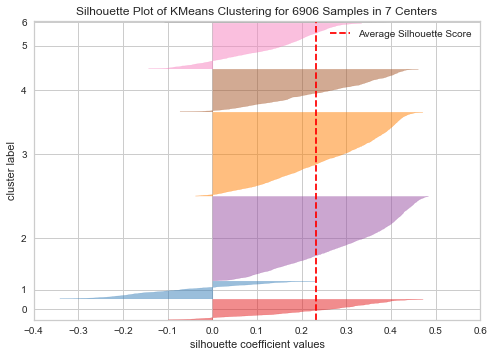

In [13]:
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [14]:
# check silhouette score
visualizer.silhouette_score_

0.23167398306431475

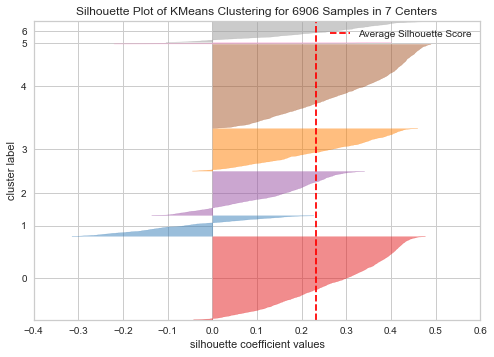

In [15]:
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [16]:
# check silhouette score
visualizer.silhouette_score_

0.2320539128711704

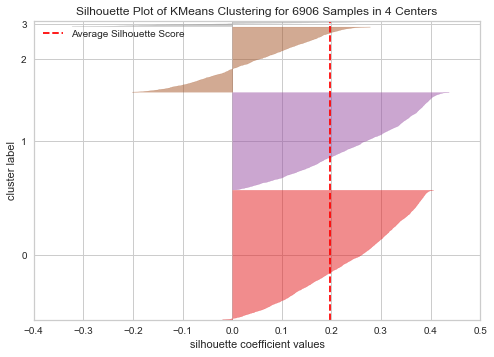

In [17]:
model2 = KMeans(4)
visualizer2 = SilhouetteVisualizer(model2)

visualizer2.fit(X)        # Fit the data to the visualizer
visualizer2.show()        # Finalize and render the figure

In [18]:
# check silhouette score
visualizer2.silhouette_score_

0.19674702844242117

## Create clusters

In [19]:
# Number of clusters
kmeans = KMeans(n_clusters=4)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

labels = kmeans.labels_

In [20]:
# combine cluster grouping w/data
clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)

## Examine clusters

In [21]:
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.40,0.166667,0.000000,0.083333,2,1000.0,201.802084,139.509787,0.0,12,2
1,2495.148862,1.000000,773.17,773.17,0.00,1.000000,1.000000,0.000000,12,7500.0,622.066742,627.284787,0.0,12,3
2,1666.670542,0.636364,1499.00,1499.00,0.00,0.083333,0.083333,0.000000,1,7500.0,0.000000,0.000000,0.0,12,2
3,817.714335,1.000000,16.00,16.00,0.00,0.083333,0.083333,0.000000,1,1200.0,678.334763,244.791237,0.0,12,2
4,1809.828751,1.000000,1333.28,0.00,1333.28,0.666667,0.000000,0.583333,8,1800.0,1400.057770,2407.246035,0.0,12,0


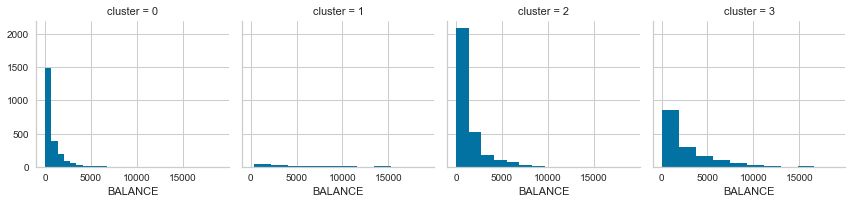

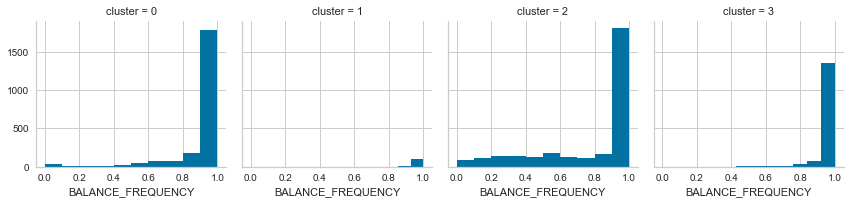

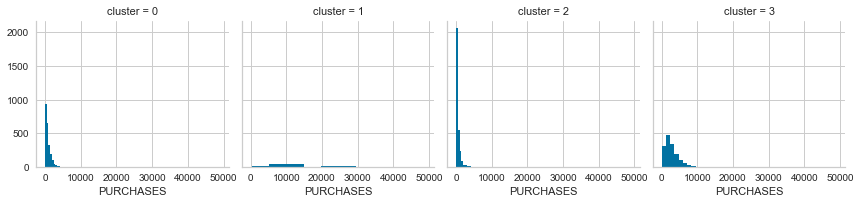

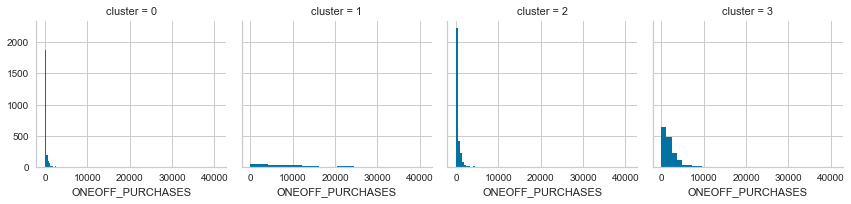

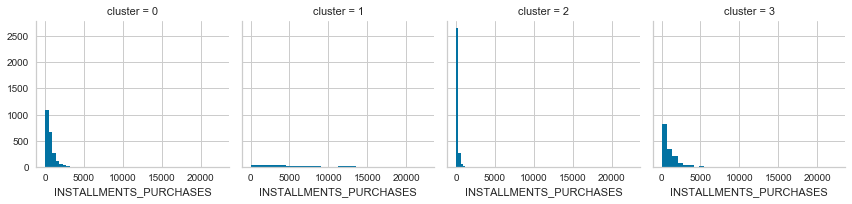

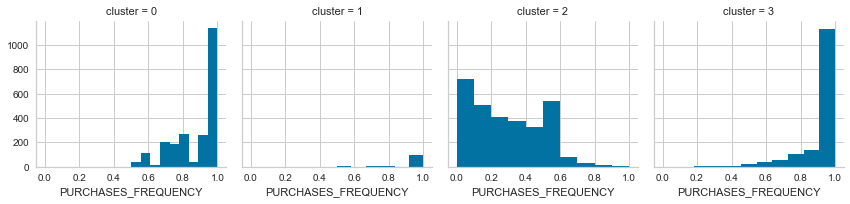

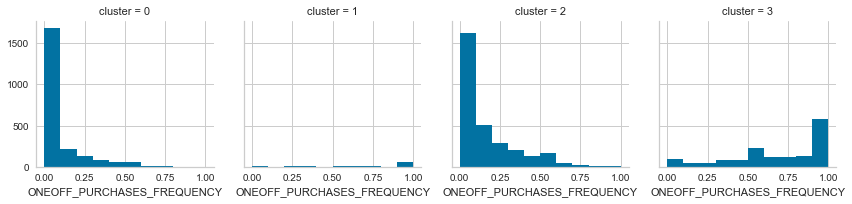

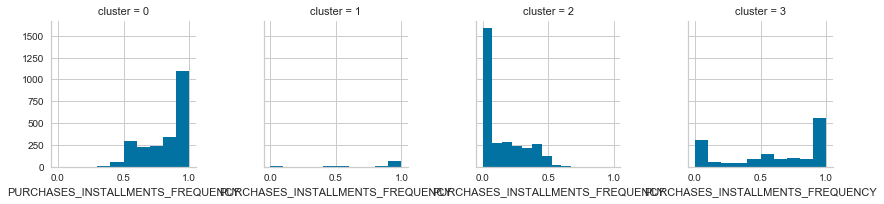

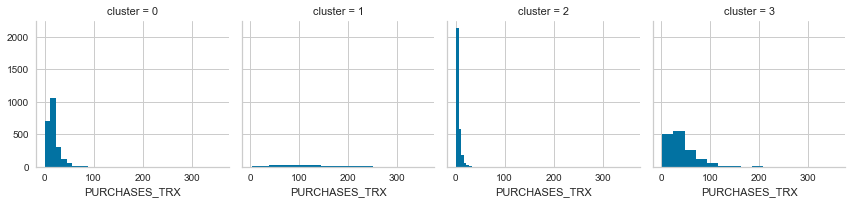

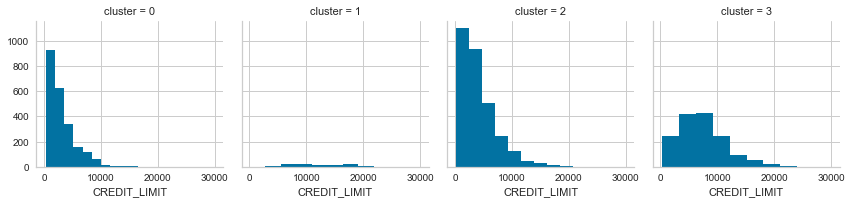

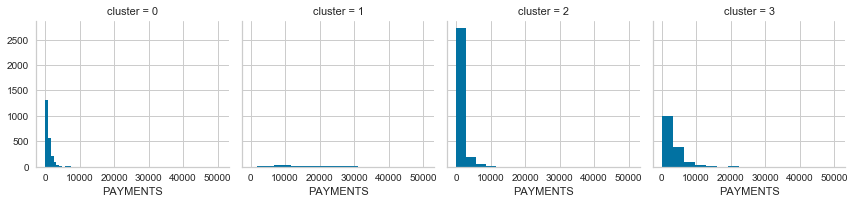

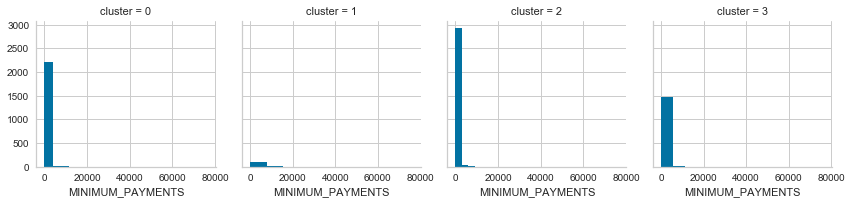

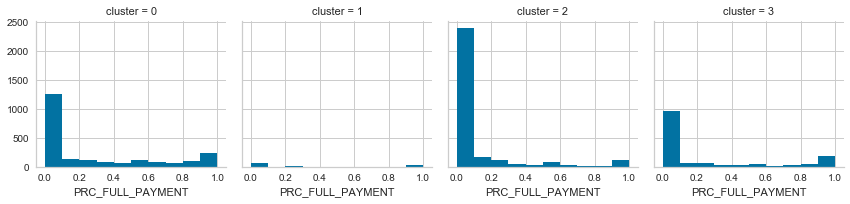

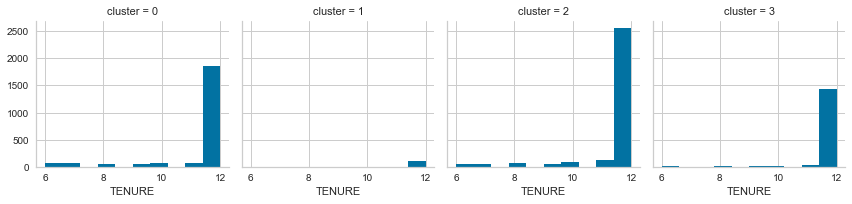

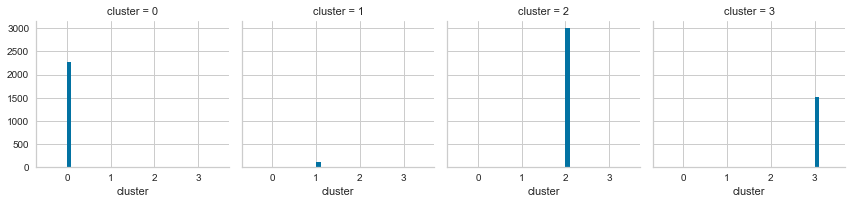

In [22]:
# Visualize resulting clusters
for cluster in clusters:
    grid = sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, cluster)

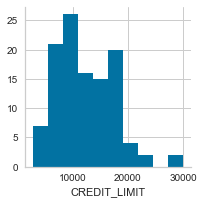

In [48]:
# Visualize resulting clusters
cl1 = clusters.loc[clusters['cluster'] == 1]
grid2 = sns.FacetGrid(cl1)
grid2.map(plt.hist, 'CREDIT_LIMIT')


In [25]:
# get cluster sizes
clusters['cluster'].value_counts()

2    3015
0    2263
3    1515
1     113
Name: cluster, dtype: int64

In [23]:
print(centroids) # From sci-kit learn

[[-0.33584236  0.16859607 -0.20566309 -0.32685196  0.1226631   0.73487066
  -0.57113001  0.90655469 -0.06622379 -0.4023845  -0.26353922 -0.06164916
   0.25252272 -0.14989026]
 [ 1.68083695  0.43337512  5.22767436  4.4006142   4.14646125  0.87534295
   1.4573871   0.84314304  3.90776478  2.01834341  4.44092199  1.18760387
   0.49208017  0.27255258]
 [-0.07282786 -0.36501792 -0.3477138  -0.21114788 -0.42747695 -0.99944303
  -0.3109631  -0.8738157  -0.51016551 -0.15055397 -0.19799804 -0.07070931
  -0.28663894 -0.01459361]
 [ 0.5204397   0.44119623  0.60800926  0.57915962  0.35718611  0.82359644
   1.36105094  0.32036801  0.82097278  0.74894029  0.45559208  0.14394197
   0.15595198  0.23228331]]
